In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from skimage import color
from skimage import io
import numba
from numba import jit
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs
from scipy import sparse
from skimage import measure
import torch
import plotly.graph_objects as go
from torch import lobpcg
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
N = 100
grid = np.zeros((N,N))
X, Y = np.mgrid[0:1:N*1j,0:1:N*1j]

Dirichilet Boundary conditions

In [3]:
Vd=10
Vs=1
Vg=5

ld=30
lg=20
lsu=5
lsd=5

w1=20
w2=30
w3=15
w4=35

grid[0,0:ld]=Vd
grid[w1,ld+lsu+lsd:ld+lsu+lsd+lg]=Vg
grid[0,ld+2*lsu+2*lsd+lg:ld+2*lsu+2*lsd+lg+ld]=Vs

mask_drain = grid==Vd
mask_gate = grid==Vg
mask_source = grid==Vs

Neumann Boundary Conditions

In [4]:

def neumann(a):
    a[0,ld:ld+lsu] = a[1,ld:ld+lsu]
    a[0,ld+lsu+lsd+lg+lsd:ld+lsu+lsd+lg+lsd+lsu] = a[1,ld+lsu+lsd+lg+lsd:ld+lsu+lsd+lg+lsd+lsu]
    a[0:w1,ld+lsu] = a[0:w1,ld+lsu-1]
    a[0:w1,ld+lsu+lsd+lg+lsd] = a[0:w1,ld+lsu+lsd+lg+lsd+1]
    a[w1,ld+lsu:ld+lsu+lsd] = a[w1-1,ld+lsu:ld+lsu+lsd]
    a[w1,ld+lsu+lsd+lg:ld+lsu+lsd+lg+lsd] = a[w1-1,ld+lsu+lsd+lg:ld+lsu+lsd+lg+lsd]
    a[0:N,0]=a[0:N,1]
    a[0:N,-1]=a[0:N,-2]
    a[-1,:]=a[-2,:]
    return a

In [5]:
#Psi boundary condtions
def psi_boundary(a):
    a[0:w1,ld+lsu:ld+lsu+lsd+lg+lsd]=0
    a[0,0:ld+lsu]=0
    a[0,ld+lsu+lsd+lg+lsd:ld+lsu+lsd+lg+lsd+lsu+ld]=0
    a[0:w1+w2+w3+w4,0]=0
    a[0:w1+w2+w3+w4,-1]=0
    return a
    

In [6]:
from scipy.ndimage import convolve, generate_binary_structure
kern = generate_binary_structure(2,1).astype(float)/4
kern[1,1] = 0
kern

array([[0.  , 0.25, 0.  ],
       [0.25, 0.  , 0.25],
       [0.  , 0.25, 0.  ]])

In [7]:
def get_Hamiltonian(V):
    diag = np.ones([N])
    diags = np.array([diag, -2*diag, diag])
    D = sparse.spdiags(diags, np.array([-1,0,1]), N, N)
    T = -1/2 * sparse.kronsum(D,D)
    U = sparse.diags(V.reshape(N**2), (0))
    H = T+U
    H = H.tocoo()
    H = torch.sparse_coo_tensor(indices=torch.tensor([H.row, H.col]), values=torch.tensor(H.data), size=H.shape).to(device)
    return H 


In [8]:

def get_e(n):
    return eigenvectors.T[n].reshape((N,N)).cpu().numpy()


In [9]:
#some constants:
me=9.1*(10**(-31))
q=-1.6*10**(-19)
m_AlN=0.27*me
m_GaN=0.18*me
m_AlGaN=0.2*me
k=1.38*(10**(-23))
T=298
h = 1.054*(10**(-34))
Ec_AlGaN=-2.4 # relative everything needs to be ev
Ec_GaN=-3.5
Eg_GaN=3.4
Eg_AlN=6.2
Eg_AlGaN=4.45
Ef_AlGaN=Ec_AlGaN-Eg_AlGaN/2.0
Ef_GaN=Ec_GaN-Eg_GaN/2.0
kT=0.025

In [10]:
import math
from math import pi, log, exp
def get_nxy(E_div_alpha,eigenvectors):
    ans = np.zeros((N,N))
    for i in range(len(E_div_alpha)):
        nxy = np.zeros((N,N))
        psi = get_e(i)
        psi = psi_boundary(psi)
        psi_squared = psi**2
        
        nxy[0:w1+w2,:] = psi_squared[0:w1+w2,:]*((2*m_AlGaN*k*T)/(pi * h**2))*log(1+exp((-Ef_AlGaN+E_div_alpha[i])/kT))
        nxy[w1+w2:w1+w2+w3,:] = psi_squared[w1+w2:w1+w2+w3,:]*((2*m_GaN*k*T)/(pi * h**2))*log(1+exp((-Ef_GaN+E_div_alpha[i])/kT))
        nxy[w1+w2+w3:,:]=psi_squared[w1+w2+w3:,:]*((2*m_AlGaN*k*T)/(pi * h**2))*log(1+exp((-Ef_AlGaN+E_div_alpha[i])/kT))
        ans=ans+nxy
    return ans

        

In [11]:
import math
err = []
iters = 100
grid = np.zeros((N,N))+0.1
for i in range(iters):
    grid_updated = convolve(grid,kern, mode='constant')
    # Boundary conditions (neumann)
    grid_updated = neumann(grid_updated)
    # Boundary conditions (dirchlett)
    grid_updated[mask_drain] = Vd
    grid_updated[mask_gate] = Vg
    grid_updated[mask_source] = Vs
    # See what error is between consecutive arrays
    
    grid_updated[0:w1+w2,:]=grid_updated[0:w1+w2,:]-Ec_AlGaN/(-1.6)
    grid_updated[w1+w2:w1+w2+w3,:]=grid_updated[w1+w2:w1+w2+w3,:]-Ec_GaN/(-1.6)
    grid_updated[w1+w2+w3:N,:]=grid_updated[w1+w2+w3:N,:]-Ec_AlGaN/(-1.6)
    
  
    grid_updated[mask_drain] = Vd
    grid_updated[mask_gate] = Vg
    grid_updated[mask_source] = Vs
    err.append(np.mean((grid-grid_updated)**2))
    grid=grid_updated
    eigenvalues, eigenvectors = lobpcg(get_Hamiltonian(grid), k=3, largest=False)
    alpha = eigenvalues[0]/2
    E_div_alpha = eigenvalues/alpha
    eigenvectors_cpu = eigenvectors.cpu()
    #print(len(E_div_alpha))
    
    nxy = get_nxy(E_div_alpha,eigenvectors_cpu)
    

    
    

/tmp/ipykernel_24/2592285004.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:245.)
  H = torch.sparse_coo_tensor(indices=torch.tensor([H.row, H.col]), values=torch.tensor(H.data), size=H.shape).to(device)


In [12]:
np.max(nxy)

4.66020132085579e+16

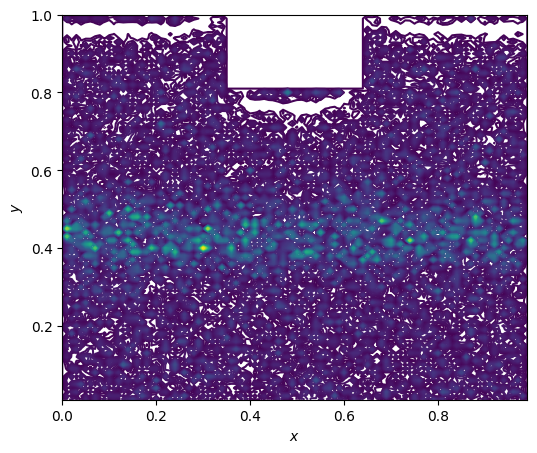

In [13]:
plt.figure(figsize=(6, 5))
CS = plt.contour(np.arange(100) / 100, 1 - np.arange(100) / 100, nxy, levels=100)
#plt.clabel(CS, CS.levels, inline=True, fontsize=6)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()  

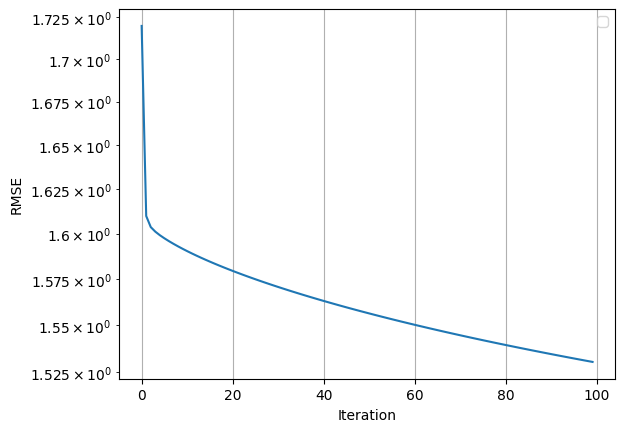

In [14]:
plt.semilogy(np.sqrt(np.array(err)))
plt.legend()
plt.xlabel('Iteration', fontsize=10)
plt.ylabel(r'RMSE')
plt.grid()

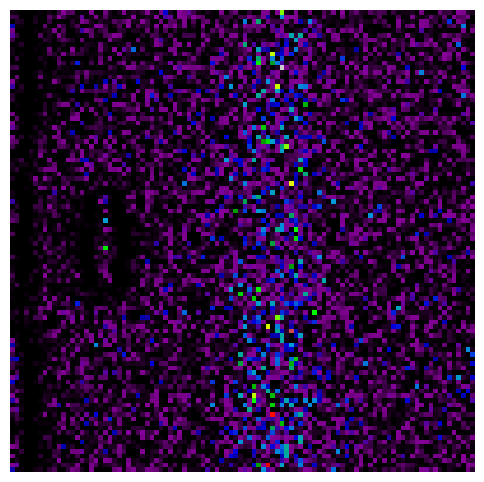

In [15]:
plt.figure(figsize=(6,6))
plt.pcolormesh(X, Y, get_e(1)**2, cmap='nipy_spectral')
plt.axis('off')
plt.show()

Text(0.5, 0, '$\\propto|\\psi|^2$')

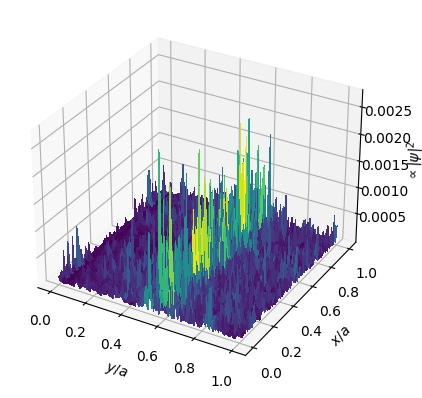

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface
ax.plot_surface(X, Y, get_e(0)**2, cmap='viridis', antialiased=False)

# Add labels
ax.set_xlabel('$y/a$')
ax.set_ylabel('$x/a$')
ax.set_zlabel('$\propto|\psi|^2$')

Text(0.5, 0, '$\\propto|\\psi|^2$')

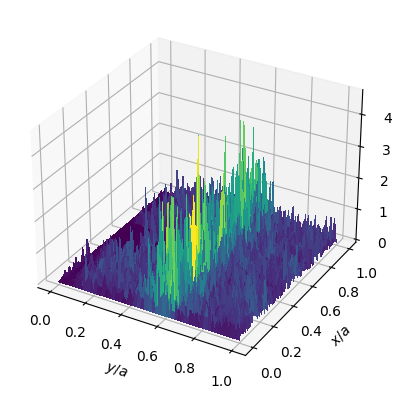

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface
ax.plot_surface(X, Y,nxy, cmap='viridis', antialiased=False)

# Add labels
ax.set_xlabel('$y/a$')
ax.set_ylabel('$x/a$')
ax.set_zlabel('$\propto|\psi|^2$')

In [18]:
def get_potential(x, y):
    #return np.exp(-(x-0.3)**2/(2*0.1**2))*np.exp(-(y-0.3)**2/(2*0.1**2))
    return 0*x
V = get_potential(X,Y)

In [19]:
V.shape

(100, 100)

In [20]:
eigenvalues, eigenvectors = eigsh(get_hamiltonian(V), k=4, which='SM')

NameError: name 'get_hamiltonian' is not defined

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(nxy, cmap='nipy_spectral')
plt.show()

In [ ]:
alpha = eigenvalues[0]/2
mapy=(get_e(0)**2)[0:w1+w2,:]*((2*m_AlGaN*k*T)/(p))*log(1+exp((Ef_AlGaN-eigenvalues[0]/alpha)/kT))

In [ ]:
plt.imshow((get_e(0)**2)[0:w1+w2,:],cmap='nipy_spectral')
plt.show()

In [ ]:
 ((2 * m_AlGaN * k * T) / (np.pi * h)) * np.log(1 + np.exp((Ef_AlGaN - eigenvalues[0].cpu().item()/ alpha) / kT))

In [ ]:
import numpy as np

# Move eigenvalues to the CPU
eigenvalues_cpu = eigenvalues.cpu()

# Calculate alpha
alpha = eigenvalues_cpu[0].item() / 2

# Calculate the expression
expression = ((2 * m_AlGaN * k * T) / (np.pi * h**2) )* np.log(1 + np.exp((Ef_AlGaN - eigenvalues_cpu[0].item() /(-1*alpha)) / kT))


In [ ]:
((2 * m_AlGaN * k * T) / (np.pi * h**2))

In [ ]:
eigenvalues_cpu[0].item()/(alpha)

In [ ]:
Ef_AlGaN 

In [ ]:
np.log(1 + np.exp((-Ef_AlGaN + eigenvalues_cpu[0].item()/(-alpha))/ kT))

In [ ]:
 np.exp((Ef_AlGaN - eigenvalues_cpu[0].item()/(alpha))/ kT)